In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#После проведения EDA (блок ниже), написал функцию по предобработке данных для любого датафрейма, тест, трайн или фичи
#Сразу удаляем лишнюю колонку, преобразуем дату и переводи в int нужные признаки (например target и vas_id)
def prepare_data(data_df, columns_to_int=None):
    data_df['buy_time'] = pd.to_datetime(data_df['buy_time'], unit='s')
    try:
        data_df = data_df.drop(columns='Unnamed: 0')
    except KeyError:
        pass
    if columns_to_int:
        try:
            data_df[columns_to_int] = data_df[columns_to_int].astype('int64')
        except KeyError:
            print("Column doesn't exist, or isn't numeric type. Unable to convert type to int. Correct key mistakes, and try again")
    return data_df

### Загрузка и просмотр датасета

In [3]:
#Убираем фиктивные колонки, видимо индексы, преобразуем даты, чтобы увидеть больше информации из имеющихся данных
df_train = pd.read_csv('data_train.csv')
df_train = prepare_data(df_train, columns_to_int=['vas_id', 'target'])
df_test = pd.read_csv('data_test.csv')
df_test = prepare_data(df_test, columns_to_int='vas_id')
df_train

,id,vas_id,buy_time,target
0,540968,8,2018-09-16 21:00:00,0
1,1454121,4,2018-07-15 21:00:00,0
2,2458816,1,2018-08-12 21:00:00,0
3,3535012,5,2018-09-02 21:00:00,0
4,1693214,1,2018-09-02 21:00:00,0
...,...,...,...,...
831648,3812226,2,2018-12-30 21:00:00,0
831649,2480469,2,2018-12-30 21:00:00,0
831650,158236,2,2018-12-30 21:00:00,0
831651,1825525,2,2018-12-30 21:00:00,0


In [4]:
df_test

,id,vas_id,buy_time
0,3130519,2,2019-01-20 21:00:00
1,2000860,4,2019-01-20 21:00:00
2,1099444,2,2019-01-06 21:00:00
3,1343255,5,2019-01-13 21:00:00
4,1277040,2,2019-01-06 21:00:00
...,...,...,...
71226,2502453,5,2019-01-20 21:00:00
71227,1693213,2,2019-01-20 21:00:00
71228,1891350,2,2019-01-20 21:00:00
71229,2437172,2,2019-01-20 21:00:00


In [5]:
%%time
#Датафрейм очень большой, поэтому решил открывать пандасом только n-первых строк от него.
#UPD: Для максимального извлечения данных для обучения на мердж, прогружал 4250000 строк, почти весь датасет, больше в озу не умещается. Из этих данных намерджил 800000 объектов для обучения
#UPD2: После 2го этапа, в числе строк будет стоять 1000000, для обзора - достаточно

df_features = pd.read_csv('features.csv.zip', sep='\t', engine='c', nrows=1000000)
#df_features = dd.read_csv('features.csv.zip', sep='\t')
df_features = prepare_data(df_features)
df_features

CPU times: total: 1min 7s
Wall time: 1min 7s


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-15 21:00:00,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,2018-10-14 21:00:00,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,2018-12-23 21:00:00,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,2018-08-12 21:00:00,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,2018-08-05 21:00:00,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1479271,2018-08-26 21:00:00,-96.799971,-389.789112,-110.740786,-442.396798,-116.158246,-463.50179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
999996,1479538,2018-12-16 21:00:00,-96.799971,-106.989112,-110.740786,-155.786798,-116.158246,-176.89179,-16.08618,-65.076097,...,-719.373846,-452.770792,-25.996269,-37.630448,-214.747724,-17.832889,-0.694428,-12.175933,-0.45614,0.0
999997,1479710,2018-07-22 21:00:00,496.820029,217.200888,482.879214,164.593202,477.461754,143.48821,-16.08618,-65.076097,...,-542.373846,-180.770792,-13.996269,-22.630448,200.252276,4.167111,-0.694428,2.824067,14.54386,1.0
999998,1479802,2018-12-23 21:00:00,-86.209971,-206.909112,-100.150786,-259.516798,-105.568246,-280.62179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


### 1. EDA (Explore Data Analysis)

In [6]:
df_features.describe()

,id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2.180561e+06,0.311083,1.095579,0.300773,1.267346,0.242721,1.288137,0.133149,0.383473,0.027938,...,0.911607,1.151224,0.662141,0.114300,0.309812,0.175095,0.020832,0.127691,-0.003491,0.256450
std,1.259488e+06,194.526908,407.475092,205.887966,473.547919,222.509800,535.861727,107.264796,266.556822,74.750517,...,3210.529144,2253.731273,1299.041785,297.742497,1353.257227,261.976069,22.382573,171.601335,5.112388,0.858694
min,1.000000e+01,-1376.469971,-1248.849112,-1377.690786,-1297.216798,-1385.638246,-2009.131790,-583.036180,-802.356097,-573.733660,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,1.090815e+06,-96.799971,-208.739112,-110.740786,-242.389298,-116.158246,-259.351790,-16.086180,-65.076097,-6.783660,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,2.181374e+06,-84.939971,-60.539112,-85.300786,-78.606798,-87.458246,-92.891790,-16.086180,-65.076097,-6.783660,...,-958.373846,-613.770792,-25.996269,-37.630448,-239.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,3.270645e+06,12.530029,118.940888,28.079214,126.985702,29.671754,120.218210,-16.086180,-59.146097,-6.783660,...,-485.373846,-409.770792,-24.996269,-33.630448,-77.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,4.362732e+06,34238.730029,65201.990888,34226.909214,84573.173202,35068.101754,84552.068210,34319.443820,65545.093903,34084.599340,...,287671.626154,190469.229208,980158.003731,32650.369552,227310.252276,97500.167111,18923.305572,97507.824067,1332.543860,342.000000


In [7]:
#Смотрим на число уникальный значений признака. Вероятно если одно значание - признак бесполезен, его можно выбросить
df_features.nunique().sort_values()

85          1
75          1
81          1
203         1
139         1
        ...  
207    603281
117    623851
38     711608
116    733585
id     992773
Length: 255, dtype: int64

In [8]:
#Смотрю Null. Они отсутствуют везде, значит их не нужно обрабатывать
df_features.isna().sum()

id          0
buy_time    0
0           0
1           0
2           0
           ..
248         0
249         0
250         0
251         0
252         0
Length: 255, dtype: int64

In [9]:
df_train.isna().sum()

id          0
vas_id      0
buy_time    0
target      0
dtype: int64

In [10]:
df_test.isna().sum()

id          0
vas_id      0
buy_time    0
dtype: int64

In [11]:
#Смотрю даты
df_features['buy_time'].unique()

array(['2018-07-15T21:00:00.000000000', '2018-10-14T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-09-23T21:00:00.000000000', '2018-12-09T21:00:00.000000000',
       '2018-09-09T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-11-04T21:00:00.000000000', '2018-09-16T21:00:00.000000000',
       '2018-07-08T21:00:00.000000000', '2018-09-30T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-12-30T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2019-01-13T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2019-01-20T21:00:00.000000000', '2018-11-11T21:00:00.000000000',
       '2018-07-29T21:00:00.000000000', '2019-01-06

In [12]:
#Смотрю время теста, сортируя
test_time = sorted(df_test['buy_time'].unique())
test_time

[numpy.datetime64('2019-01-06T21:00:00.000000000'),
 numpy.datetime64('2019-01-13T21:00:00.000000000'),
 numpy.datetime64('2019-01-20T21:00:00.000000000')]

In [13]:
#Смотрю время трейна, сортируя
#Видно что на трейн, уходит 6 месяцев, а на тест один. Также видно что даты в трейн/тест и у фичей совершенно одинаковые. Это значит что можно мержить фичи в трейн/тест по паре id + дата, т.к пара id и дата полностью описывают параметры пользователей
train_time = sorted(df_train['buy_time'].unique())
train_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [14]:
feature_time = sorted(df_features['buy_time'].unique())
feature_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [15]:
df_train['vas_id'].unique()

array([8, 4, 1, 5, 2, 7, 6, 9], dtype=int64)

In [16]:
#Видно что услуг всего 9, их надо преобразовать в int
df_test['vas_id'].unique()

array([2, 4, 5, 6, 1, 7, 8, 9], dtype=int64)

In [17]:
#Просмотр баланса классов на тесте
feats = df_train.drop(columns='target')
target = df_train['target']
feats

,id,vas_id,buy_time
0,540968,8,2018-09-16 21:00:00
1,1454121,4,2018-07-15 21:00:00
2,2458816,1,2018-08-12 21:00:00
3,3535012,5,2018-09-02 21:00:00
4,1693214,1,2018-09-02 21:00:00
...,...,...,...
831648,3812226,2,2018-12-30 21:00:00
831649,2480469,2,2018-12-30 21:00:00
831650,158236,2,2018-12-30 21:00:00
831651,1825525,2,2018-12-30 21:00:00


In [18]:
target

0         0
1         0
2         0
3         0
4         0
         ..
831648    0
831649    0
831650    0
831651    0
831652    0
Name: target, Length: 831653, dtype: int64

0    0.927631
1    0.072369
Name: target, dtype: float64

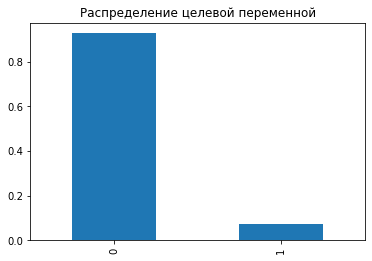

In [19]:
#Очень сильный дизбаланс классов. Возможно во время обучения нужно использовать деревья или мощные ансамбли (LightGBM или CatBoost?)
(target.value_counts()/target.shape[0]).plot(kind='bar', title='Распределение целевой переменной')
target.value_counts()/target.shape

In [20]:
%%time
#Исследвание фичей
features_copy = df_features.copy()
features_copy.set_index('id')
features_copy.drop(columns=['buy_time'], inplace=True)
feature_nunique = features_copy.apply(lambda x: x.nunique(dropna=False))
feature_nunique.shape

CPU times: total: 6.34 s
Wall time: 6.42 s


(254,)

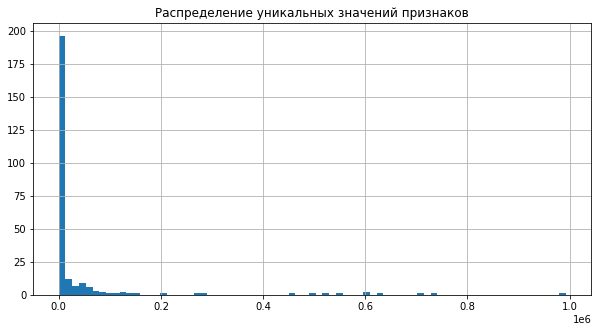

In [21]:
#Распределение значений
plt.title("Распределение уникальных значений признаков")
feature_nunique.hist(bins=75,figsize=(10, 5));

In [22]:
#Все признаки
f_all = set(feature_nunique.index.tolist())
len(f_all)

254

In [23]:
#Константные признаки, подлежат удалению (неиспользованию в обучении модели)
f_const = set(feature_nunique[feature_nunique == 1].index.tolist())
len(f_const)

5

In [24]:
f_const

{'139', '203', '75', '81', '85'}

In [25]:
%%time
#Вещественные признаки
f_numeric = (features_copy.fillna(0).astype(int).sum() - features_copy.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

CPU times: total: 3.89 s
Wall time: 4.01 s


247

In [26]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

2

In [27]:
#Остается 2 признака, id это понятно и 2ой скорее всего бинарный, посмотрим на него
f_other

{'252', 'id'}

In [28]:
#Видно что целочисленный, можно кидать в предобработку его на целое число, не категория определенно
features_copy['252'].nunique()

32

### Итоги EDA, выводы
1. Отсутствуют Null, id уникальны можно поставить индексом в датафреймах
2. Признаки с разными уникальными значениями, там где одно уникальное значение - их можно удалить, они не несут никакого смысла
3. Даты в фичах и в трейн/тест - одинаковые уникальные значения, это хорошо можно сразу мерджить фичи в трейн/тест данные по id + buy_time
4. Сильный дизбаланс классов, линейные модели вряд ли обучатся хорошо. Нужно использовать ансамбли или случайные леса скорее всего.
5. Target, vas_id нужно преобразовать в Int
6. Все признаки у которых уникальные значения в диапазоне от 2 до 30 считаем категориальными на старте
7. При попадании данных в пайплайн постараться делать сразу 3 действия: buy_time преобразовывать в date_time, делать drop 'Unnamed: 0', делать лефт мердж  по id и buy_time


UPD: Во второй ячейке написал функцию по первичной предобработке данных, по пункту 7 + сразу преобразовывает в инт указанные колонки
UPD2: Просмотрел фичи в датасете с фичами, теперь мерджить и писать пайплайны

### 2. Подготовка данных для обучения модели (Feature Engineering)

In [29]:
#Выбираем признаки для обучения
f_other.add('buy_time')
f_ok = list(f_other | f_numeric)
feats = df_features[f_ok]
feats

,6,96,158,56,101,95,80,22,49,107,...,215,121,90,27,140,93,169,234,211,138
0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.571103,4.027863,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-23.961228,-32.356505,-61790.157098,4.064012
1,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.567778,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-25.961228,2.643495,-61790.157098,-1.935988
2,3.51382,-0.250188,-0.536315,-0.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.567090,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,8.038772,123.643495,-61790.157098,-1.935988
3,-16.08618,-0.250188,-0.536315,-0.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.571103,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-21.961228,956.643495,-61813.537098,6.064012
4,-16.08618,6.109812,-0.536315,-1.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.571103,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-25.961228,901.643495,-61790.157098,-1.935988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.571103,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-25.961228,-35.356505,-61790.157098,-1.935988
999996,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.571103,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,31.038772,-11.356505,-61790.157098,-1.935988
999997,-16.08618,-0.250188,6.463685,3.328676,-0.253037,-0.000115,-0.203232,-0.094251,-28.571103,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,65.038772,-34.356505,-61790.157098,46.064012
999998,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,-0.203232,-0.094251,-28.571103,-0.212137,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-8.961228,-35.356505,-61790.157098,-1.935988


In [30]:
%%time
#Мерджим наш трейн с признаками по id. Даты получится 2 штуки, buy_time услуги и время сбора информации об абоненте. Также планирую добавить еще одну фичу, которая будет отвечать за разницу этого времени. Полагаю что чем значение больше ее будет, тем хуже, т.к информация об абоненте менее актуальна
train_feats = df_train.merge(feats, how='inner', on='id')
train_feats

CPU times: total: 2.86 s
Wall time: 2.9 s


,id,vas_id,buy_time_x,target,6,96,158,56,101,95,...,215,121,90,27,140,93,169,234,211,138
0,1693214,1,2018-09-02 21:00:00,0,-16.08618,-0.250188,-0.536315,-0.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-14.961228,11.643495,-61771.833764,-1.935988
1,3577737,5,2018-12-23 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,8.038772,-2.356505,-61790.157098,21.064012
2,1232876,2,2018-12-16 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-18.961228,60.643495,-61790.157098,-1.935988
3,1387603,4,2018-09-02 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,31.038772,870.643495,-61794.877098,-1.935988
4,1409615,2,2018-09-16 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-16.961228,-35.356505,-61790.157098,-1.935988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190791,3173649,2,2018-12-30 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-17.961228,-35.356505,-61790.157098,-1.935988
190792,2545695,5,2018-12-30 21:00:00,0,-16.08618,-0.250188,0.463685,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-5.961228,-27.356505,-61790.157098,-1.935988
190793,3388613,5,2018-12-30 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-24.961228,-34.356505,-61790.157098,-1.935988
190794,3897358,2,2018-12-30 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-11.961228,0.643495,-61790.157098,-1.935988


In [31]:
%%time
#Преобразование дат и просмотр датасета
#train_feats['buy_time_x'] = pd.to_datetime(train_feats['buy_time_x'], unit='s')
#train_feats['buy_time_y'] = pd.to_datetime(train_feats['buy_time_y'], unit='s')
train_feats.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_recieve_time'}, inplace=True)
train_feats[['id', 'vas_id', 'buy_time', 'data_recieve_time', 'target']]

CPU times: total: 15.6 ms
Wall time: 8.98 ms


,id,vas_id,buy_time,data_recieve_time,target
0,1693214,1,2018-09-02 21:00:00,2018-11-25 21:00:00,0
1,3577737,5,2018-12-23 21:00:00,2018-07-08 21:00:00,0
2,1232876,2,2018-12-16 21:00:00,2018-07-22 21:00:00,0
3,1387603,4,2018-09-02 21:00:00,2019-01-20 21:00:00,0
4,1409615,2,2018-09-16 21:00:00,2018-12-16 21:00:00,0
...,...,...,...,...,...
190791,3173649,2,2018-12-30 21:00:00,2019-01-13 21:00:00,0
190792,2545695,5,2018-12-30 21:00:00,2018-07-22 21:00:00,0
190793,3388613,5,2018-12-30 21:00:00,2018-12-16 21:00:00,0
190794,3897358,2,2018-12-30 21:00:00,2018-12-09 21:00:00,0


In [32]:
train_feats

,id,vas_id,buy_time,target,6,96,158,56,101,95,...,215,121,90,27,140,93,169,234,211,138
0,1693214,1,2018-09-02 21:00:00,0,-16.08618,-0.250188,-0.536315,-0.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-14.961228,11.643495,-61771.833764,-1.935988
1,3577737,5,2018-12-23 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,8.038772,-2.356505,-61790.157098,21.064012
2,1232876,2,2018-12-16 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-18.961228,60.643495,-61790.157098,-1.935988
3,1387603,4,2018-09-02 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,31.038772,870.643495,-61794.877098,-1.935988
4,1409615,2,2018-09-16 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-16.961228,-35.356505,-61790.157098,-1.935988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190791,3173649,2,2018-12-30 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-17.961228,-35.356505,-61790.157098,-1.935988
190792,2545695,5,2018-12-30 21:00:00,0,-16.08618,-0.250188,0.463685,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-5.961228,-27.356505,-61790.157098,-1.935988
190793,3388613,5,2018-12-30 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-24.961228,-34.356505,-61790.157098,-1.935988
190794,3897358,2,2018-12-30 21:00:00,0,-16.08618,-0.250188,-0.536315,-1.671324,-0.253037,-0.000115,...,-2.10805,-0.433135,-0.626985,-0.00909,-1.276187,-0.185299,-11.961228,0.643495,-61790.157098,-1.935988


In [33]:
#Проверка что null отсутствуют. При left join, идут null по всем признакам, а значит эти данные абсолютно бесполезные. Поэтому делаем inner join
train_feats['data_recieve_time'].isnull().sum()

0

In [34]:
#Указываем что признак 252, числовой. В будущем будет категория
train_feats['252'] = train_feats['252'].astype('int64')

In [35]:
#Сохранение полученных датасетов для обучения моделей
#train_feats.to_csv('4250k_feats_train.csv')

### Итоги 2го этапа.
1) Написал функцию по предобработке исходных данных. (Удаление колнки лишней, float_to_int, преобразование из timestamp в datetime)
2) Подготовил из 4250000 объектов с признаками (94.5% всех признаков), ~800000 для обучения модели через мердж трейна и признаков по пользователям
3) Получили 2 даты по каждому пользователю: одна - дата покупки, вторая - дата сбора информации об абоненте. Необходимо будет сделать 3ю фичу разницу этих дат в днях по модулю, она будет отражать актуальность данных об абоненте

###### Дальнейший план работы
1) Загрузить данные из заготовленного файла для трейна 4250k_feats_train.zip в нем csv
2) Перед созданием последней фичи или после, промерджить данные по id/id+buy_time, в data_train.csv. Необходимо убедиться что тест, никак не меняется по объему данных (количеству объектов или хотя бы в не меньшую сторону)
3) Разбить данные на трейн/тест, для измерения метрики. Кросс валидация по ситуации буду думать и по времени, наверное после бейзлайна уже.
4) После создания фичи, можно собирать модель/пайплайн и обучать модель. Затем gridsearch/другие модели, но исходные данные будут уже эти точно
5) Сохранение результатов и все остальные прикладные вещи

In [36]:
"""
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)
"""

'\nclass ColumnSelector(BaseEstimator, TransformerMixin):\n    def __init__(self, columns):\n        self.columns = columns\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X):\n        assert isinstance(X, pd.DataFrame)\n\n        try:\n            return X[self.columns]\n        except KeyError:\n            cols_error = list(set(self.columns) - set(X.columns))\n            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)\n'